# Setup

In [1]:
from __future__ import division, print_function, unicode_literals

#common imports
import os
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)

if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(IMAGE_PATH, fig_id + '.png')
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) #fetch_openml returns targets as str
    sort_by_target(mnist)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
    
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

Saving figure some_digit_plot


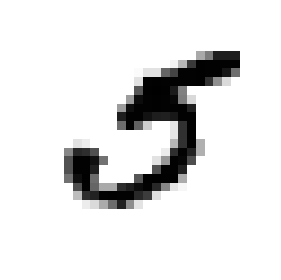

In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, -1)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')

save_fig('some_digit_plot')
plt.show()

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, interpolation='nearest', cmap=mpl.cm.binary)
    plt.axis('off')

In [9]:
# EXTRA
def plot_digits(instances, images_per_row, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros([size, size * n_empty]))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        #print(type(images))
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

Saving figure more_digits_plot


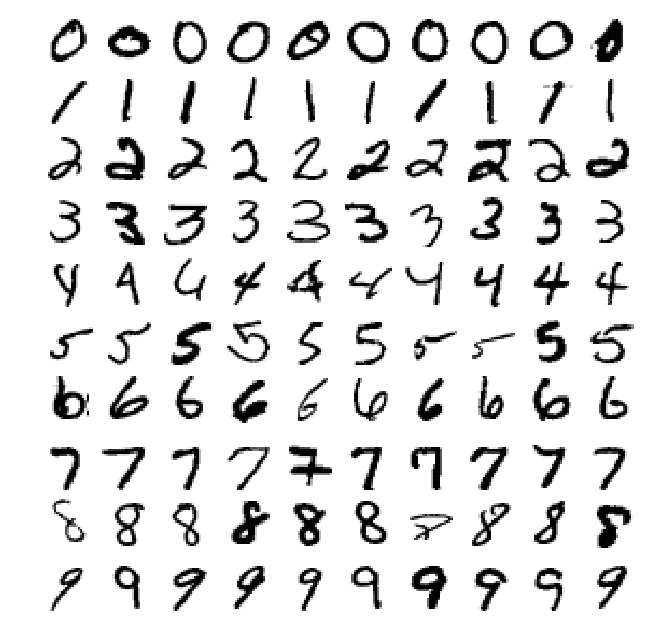

In [10]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, 10)
save_fig('more_digits_plot')
plt.show()

In [11]:
y[36000]

5

In [12]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [13]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary classifies

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [24]:
y_train_perfect_predictions = y_train_5

In [25]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [27]:
4344/(1307+4344) # precision

0.7687135020350381

In [28]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [29]:
4344/(1077+4344) # recall

0.801328168234643

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [31]:
4344 / (4344 + (1077 + 1307) / 2) # TP/(TP+(FN+FP)/2)

0.7846820809248555

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [34]:
y_some_digit_pred

array([ True])

In [35]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [37]:
y_scores.shape

(60000,)

In [38]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:,1]

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


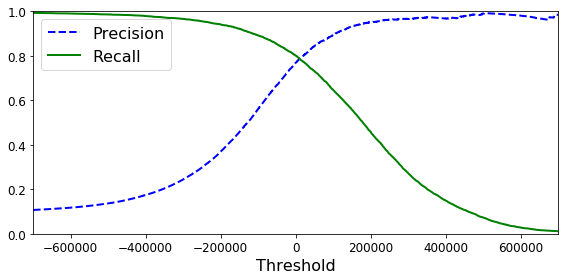

In [40]:
# plot the precision vs threshold, recall vs threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.xlabel('Threshold', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig('precision_recall_vs_threshold_plot')
plt.show()

In [41]:
(y_train_pred == (y_scores > 0)).all() # the threshold automatically chosen for y_train_pred by the algo is 0

True

In [42]:
y_train_pred_90 = (y_scores > 70000) # 70000 is determined by looking at above plot

In [43]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [44]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

Saving figure precion_vs_recall_plot


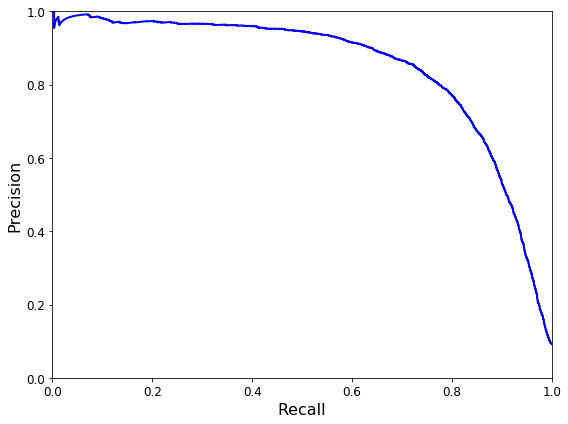

In [45]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0,1,0,1])
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
save_fig('precion_vs_recall_plot')
plt.show()

# ROC curves

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


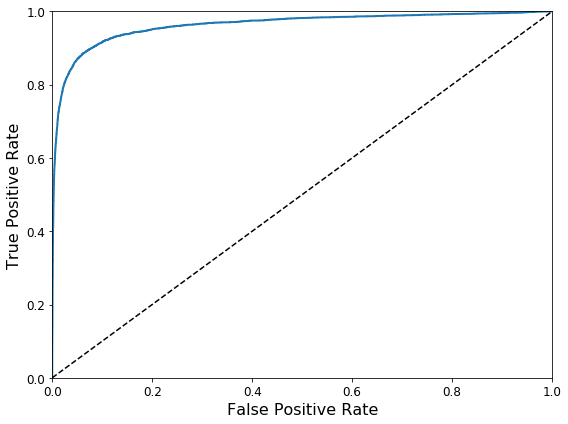

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
save_fig('roc_curve_plot')
plt.show()

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

In [49]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method='predict_proba')

In [50]:
# y_probas_forest: [score of neg class, score of pos class]
y_scores_forest = y_probas_forest[:, 1] # score=proba of positive class
fpr_forest, tpr_forest, threshold = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


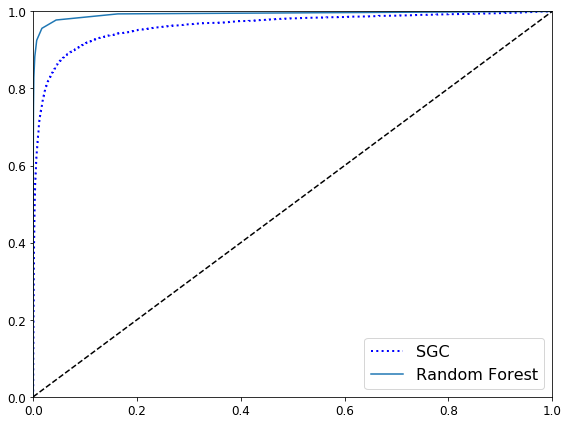

In [51]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, 'b:', label = 'SGC', linewidth=2)
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.plot([0,1], [0,1], 'k--')
plt.axis([0, 1, 0, 1])
plt.legend(loc='lover right', fontsize=16)
save_fig('roc_curve_comparison_plot')
plt.show()

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [53]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [54]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# Multiclass classfication

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [56]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [57]:
np.argmax(some_digit_scores)

5

In [58]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [59]:
sgd_clf.classes_[5]

5

In [60]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [61]:
len(ovo_clf.estimators_)

45

In [62]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [63]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.84063187, 0.84899245, 0.86652998])

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, scoring='accuracy', cv=3)

array([0.91011798, 0.90874544, 0.906636  ])

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

Saving figure confusion_matrix_plot


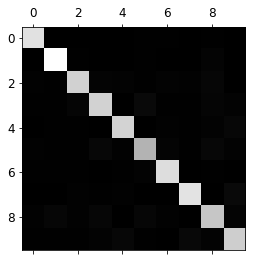

In [67]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig('confusion_matrix_plot', tight_layout=False)
plt.show()

In [68]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

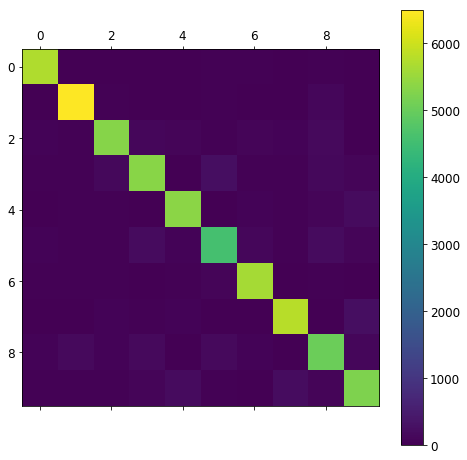

In [69]:
plot_confusion_matrix(conf_mx)
plt.show()

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


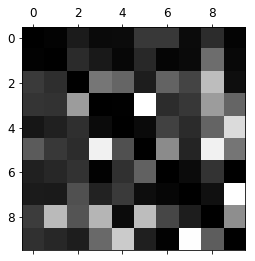

In [71]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig('confusion_matrix_errors_plot', tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


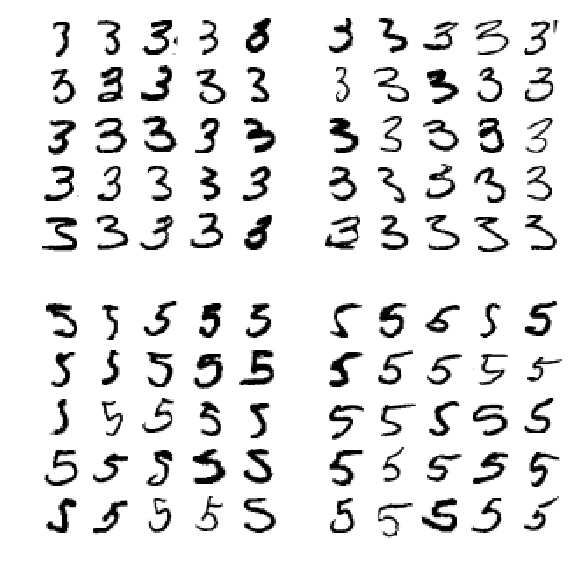

In [72]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig('error_analysis_digits_plot')
plt.show()

# Multilabel classification

In [73]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train > 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [74]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [75]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=8)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9717354633039217

# Multioutput classification

In [76]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


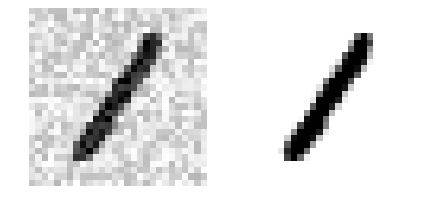

In [77]:
# different from the the notebook of the author, due to shuffle the images?
some_index = 5500
plt.subplot(121); plot_digit(X_train_mod[some_index])
plt.subplot(122); plot_digit(y_train_mod[some_index])
save_fig('noisy_digit_example_plot')
plt.show()

Saving figure clean_digit_example_plot


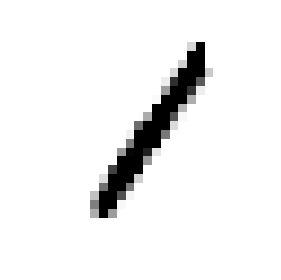

In [78]:
# knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[some_index]])
plot_digit(clean_digit)
save_fig('clean_digit_example_plot')

# Extra material

## Dummy (ie. random) classifier

In [79]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

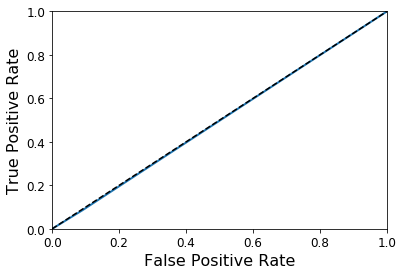

In [80]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [81]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=8, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=8, n_neighbors=4, p=2,
           weights='distance')

In [82]:
y_knn_pred = knn_clf.predict(X_test)

In [83]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

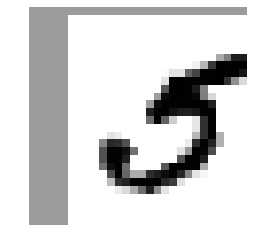

In [84]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [85]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded) # list of list, combine the inner list together
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [86]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=8, n_neighbors=4, p=2,
           weights='distance')

In [87]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [88]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [89]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.       , 0.       , 0.5053645, 0.       , 0.       , 0.       ,
        0.       , 0.4946355, 0.       , 0.       ]])

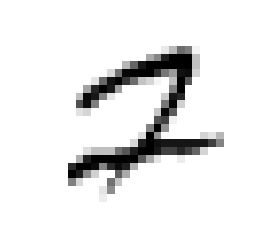

In [90]:
plot_digit(ambiguous_digit)

# Exercise solutions

## 1. An MNIST Classifier With Over 97% Accuracy

**Warning**: the next cell may take hours to run, depending on your hardware.

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=8)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed: 377.9min remaining: 58.1min
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 379.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [93]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [94]:
grid_search.best_score_

0.97325

In [96]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## Data Argumentation

- Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.
- Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set.
- Finally, train your best model on this expanded training set and measure its accuracy on the test set.

You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [97]:
from scipy.ndimage.interpolation import shift

In [103]:
def shift_image(digit_arr, dx, dy):
    return shift(digit_arr.reshape(28, 28), [dy, dx], cval=0, mode='constant').reshape(784)

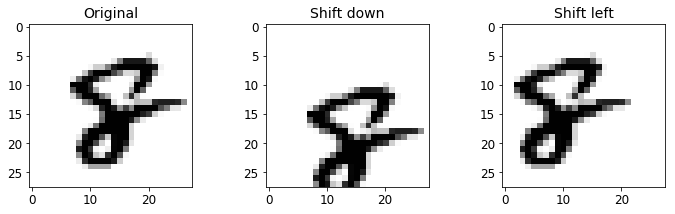

In [99]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Original', fontsize=14)
plt.imshow(image.reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.subplot(132)
plt.title('Shift down', fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.subplot(133)
plt.title('Shift left', fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), cmap='Greys', interpolation='nearest')

In [104]:
X_train_argumented = [X_train]
y_train_argumented = [y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_image, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_argumented.append(shifted_images)
    y_train_argumented.append(y_train)
    
X_train_argumented = np.concatenate(X_train_argumented)
y_train_argumented = np.concatenate(y_train_argumented)

In [105]:
shuffle_idx = np.random.permutation(len(X_train_argumented))
X_train_argumented = X_train_argumented[shuffle_idx]
y_train_argumented = y_train_argumented[shuffle_idx]

In [106]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_argumented, y_train_argumented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [107]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

In [138]:
# RAM management

import gc
del X_train_argumented, X_train_expanded, X_train_mod
del y_train_argumented, y_train_expanded, y_train_mod

gc.collect()

5721

## Tackle the Titanic dataset


The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to [Kaggle](https://www.kaggle.com) and go to the [Titanic challenge](https://www.kaggle.com/c/titanic) to download train.csv and test.csv. Save them to the datasets/titanic directory.

Next, let's load the data:

In [108]:
import os

TITANIC_PATH = os.path.join('datasets', 'titanic')

In [109]:
import pandas as pd

def load_titanic_data(filename, titanic_path = TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [110]:
train_data = load_titanic_data('train.csv')
test_data = load_titanic_data('test.csv')

In [111]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [112]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [113]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [115]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [116]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [117]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [118]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Now let's build our preprocessing pipelines. We will reuse the DataframeSelector we built in the previous chapter to select specific attributes from the DataFrame:

In [119]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('select_numercial', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])), 
    ('imputer', SimpleImputer(strategy='median'))
])


In [121]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [125]:
# Imputer for categorical columns
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X):
        return X.fillna(self.most_frequent_)

In [126]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])), 
                         ('imputer', MostFrequentImputer()), 
                         ('cat_encoder', OneHotEncoder(sparse=False))
                        ])

In [127]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [129]:
# join the numerical and categorical pipelines

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline), 
    ('cat_pipeline', cat_pipeline)
])

In [130]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [132]:
y_train = train_data['Survived']

In [133]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [134]:
X_test = preprocess_pipeline.transform(test_data)
y_test = svm_clf.predict(X_test)

In [136]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

In [137]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

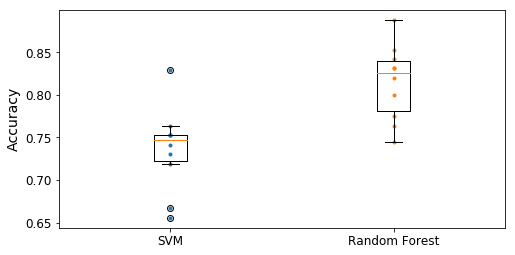

In [141]:
# plot scores for the 10 folds

plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [142]:
train_data['AgeBucket'] = train_data['Age'] // 15 * 15
train_data[['AgeBucket', 'Survived']].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [143]:
train_data['RelativesOnboard'] = train_data['SibSp'] + train_data['Parch']
train_data[['RelativesOnboard', 'Survived']].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## Spam classfier

Build a spam classifier
- Download examples of spam and ham from [Apache SpamAssassin's public dataset'](http://spamassassin.apache.org/old/publiccorpus/)
- Unzip dataset
- Write a data preparation pipeline to convert each email into a feature vector
- Try several classifiers

In [144]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = 'http://spamassassin.apache.org/old/publiccorpus/'
HAM_URL = DOWNLOAD_ROOT + '20030228_easy_ham.tar.bz2'
SPAM_URL = DOWNLOAD_ROOT + '20030228_spam.tar.bz2'
SPAM_PATH = os.path.join('datasets', 'spam')

def fetch_spam_data(spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
        
    for filename, url in (('ham.tar.bz2', HAM_URL), ('spam.tar.bz2', SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)    
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [145]:
fetch_spam_data()

In [148]:
HAM_DIR = os.path.join(SPAM_PATH, 'easy_ham')
SPAM_DIR = os.path.join(SPAM_PATH, 'spam')
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [149]:
len(ham_filenames)

2500

In [150]:
len(spam_filenames)

500

In [156]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = 'spam' if is_spam else 'easy_ham'
    with open(os.path.join(spam_path, directory, filename), 'rb') as f:
#         return email.parser.BytesParser(policy=email.policy.default).parser(f)
        email_parser = email.parser.BytesParser(policy=email.policy.default)
        return email_parser.parse(f)

In [157]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [158]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [160]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [165]:
# some email are multipart, with images and attachements
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return 'multiplart({})'.format(','.join([
            get_email_structure(sub_email) 
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [167]:
from collections import Counter

def structure_counter(emails):
    structures = Counter()
    for email in emails:
        strucure = get_email_structure(email)
        structures[strucure] += 1
    return structures

In [168]:
structure_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multiplart(text/plain,application/pgp-signature)', 66),
 ('multiplart(text/plain,text/html)', 8),
 ('multiplart(text/plain,text/plain)', 4),
 ('multiplart(text/plain)', 3),
 ('multiplart(text/plain,application/octet-stream)', 2),
 ('multiplart(text/plain,text/enriched)', 1),
 ('multiplart(text/plain,application/ms-tnef,text/plain)', 1),
 ('multiplart(multiplart(text/plain,text/plain,text/plain),application/pgp-signature)',
  1),
 ('multiplart(text/plain,video/mng)', 1),
 ('multiplart(text/plain,multiplart(text/plain))', 1),
 ('multiplart(text/plain,application/x-pkcs7-signature)', 1),
 ('multiplart(text/plain,multiplart(text/plain,text/plain),text/rfc822-headers)',
  1),
 ('multiplart(text/plain,multiplart(text/plain,text/plain),multiplart(multiplart(text/plain,application/x-pkcs7-signature)))',
  1),
 ('multiplart(text/plain,application/x-java-applet)', 1)]

In [169]:
structure_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multiplart(text/plain,text/html)', 45),
 ('multiplart(text/html)', 20),
 ('multiplart(text/plain)', 19),
 ('multiplart(multiplart(text/html))', 5),
 ('multiplart(text/plain,image/jpeg)', 3),
 ('multiplart(text/html,application/octet-stream)', 2),
 ('multiplart(text/plain,application/octet-stream)', 1),
 ('multiplart(text/html,text/plain)', 1),
 ('multiplart(multiplart(text/html),application/octet-stream,image/jpeg)', 1),
 ('multiplart(multiplart(text/plain,text/html),image/gif)', 1),
 ('multipart/alternative', 1)]

In [170]:
# Check email headers

for header, value in spam_emails[0].items():
    print(header, ':', value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [172]:
spam_emails[0]['Subject']

'Life Insurance - Why Pay More?'

In [173]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [180]:
import re
from html import unescape

'''
What is the difference between .*? and .* regular expressions?
Consider the input 101000000000100.
Using 1.*1, * is greedy - it will match all the way to the end, 
and then backtrack until it can match 1, leaving you with 1010000000001.

.*? is non-greedy. * will match nothing, 
but then will try to match extra characters until it matches 1, eventually matching 101.
'''

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I) # remove header
    text = re.sub('<a\s.*?>', ' HYPERLINK', text, flags=re.M | re.S | re.I) # find hyperlink
    text = re.sub('<.*?>', '', text, flags=re.M | re.S) #????
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S) # remove \n??
    return unescape(text)

In [177]:
html_spam_emails = [email for email in X_train[y_train==1] 
                    if get_email_structure(email) == 'text/html']
sample_email_spam = html_spam_emails[7]
print(sample_email_spam.get_content()[:1000], '...')

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [181]:
print(html_to_plain_text(sample_email_spam.get_content())[:1000], '...')


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [184]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_content) 
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)
        

In [185]:
print(email_to_text(sample_email_spam)[:100], '...')


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [194]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ('Computations', "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, '=>', stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [196]:
import urlextract

url_extractor = urlextract.URLExtract()
print(url_extractor.find_urls('Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s'))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [199]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True, 
                 replace_url=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_url = replace_url
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ''
            if self.lower_case:
                text = text.lower()
            # replace url need to be done before remove punctuation
            if (self.replace_url) and (url_extractor is not None):
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, ' URL ')
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)
                

In [200]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [214]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    
    def fit(self, X, y=None): # fit method to build the vocabulary
        total_count = Counter()
        for word_count in X: # for each email
            for word, count in word_count.items():
#                 print(count)
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row) # email idx
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [217]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [218]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  1,  3,  3,  1,  3,  2,  3],
       [63,  0,  1,  2,  5,  3,  1,  2,  0,  1,  0]], dtype=int64)

In [220]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'url': 4,
 'to': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [221]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ('email_to_wordcount', EmailToWordCounterTransformer()), 
    ('wordcount_to_vector', WordCounterToVectorTransformer())
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver='liblinear', random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=0.98125, total=   0.1s
[CV]  ................................................................
[CV] .................................. , score=0.98125, total=   0.1s
[CV]  ................................................................
[CV] ..................................... , score=0.99, total=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


0.9841666666666665

In [224]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)
log_clf = LogisticRegression(solver='liblinear', random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print('Precision: {:.2f}%'.format(100 * precision_score(y_test, y_pred)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_test, y_pred)))

Precision: 93.00%
Recall: 97.89%
